In [126]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import IPython.display as ipd
from ipynb.fs.defs.utility import *
from dataclasses import dataclass

In [127]:
FS = 48000 # the audio output sample rate

def num_samples_for_secs(s):
    return int(FS * s)

# min frequency of each oscillator
VCO_F_MIN, VCO_F_MAX = 40, 20000
LFO_F_MIN, LFO_F_MAX = 1/60, 1000

# wavetable shape indices
WAVE_SIN, WAVE_TRI, WAVE_SAW, WAVE_SQR = 0, 1, 2, 3

# import the wavetable settings
with open("wavetable_meta.dat") as wt_meta_file:
    consume_line = lambda : int(wt_meta_file.readline())
    SMPL_SIZE = consume_line()
    NUM_OCTAVES = consume_line()
    NUM_WAVES = consume_line()
        
# import the wavetable
with open("wavetable_init.dat") as wt_file:
    wavetable = [float(x) for x in wt_file.read().split(',\n')]

In [184]:
@dataclass
class Oscillator_state:
    # maintains state of oscillator between sample calculations
    k: float = 0 # wavetable index
    f: float = 0 # frequency

def gen_output(cv_stream_collection, N, show_progress=False):    
    # restart the oscillator
    osc_state = Oscillator_state()
    
    # create N samples
    output = []
    for i in range(0, N):
          
        # get the cv for this sample
        cv_ss = cv_stream_collection.get_snapshot_at(i)
        
        # create the sample
        y = gen_sample(cv_ss, osc_state)
        output.append(y)   
            
        # update the (decimal) index in the wave sample
        osc_state.k += osc_state.f * SMPL_SIZE/FS # adjust the playback rate
        osc_state.k %= SMPL_SIZE # keep k in wavetable index range
        
        # progress indication
        if show_progress:
            prog = 100*i/N
            if prog % 10 == 0:
                print(prog, "%")

    return np.array(output)

def gen_sample(cv_ss, osc_state):
    # extract the cv for each channel
    waveshape = cv_ss.get_channel(CV_CH_WAVESHAPE)
    mode = cv_ss.get_channel(CV_CH_MODE)
    coarse_adj = cv_ss.get_channel(CV_CH_COARSE_ADJ)
    fine_adj = cv_ss.get_channel(CV_CH_FINE_ADJ)
    vpo = cv_ss.get_channel(CV_CH_VPO)
    fm_exp = cv_ss.get_channel(CV_CH_FM_EXP)

    # determine the oscillator frequency
    f = translate_range(coarse_adj.converted_val, coarse_adj.range_min, coarse_adj.range_max, VCO_F_MIN, VCO_F_MAX)
    volt_from_vpo = vpo.raw_val
    f *= 2**volt_from_vpo
    volt_from_fm = fm_exp.raw_val
    f *= 2**volt_from_fm

    # clamp the frequency to within capable range - SHOULDN'T HAVE TO DO THIS ??
    f = clamp(f, VCO_F_MIN, VCO_F_MAX) # restrict f to range [VCO_F_MIN, VCO_F_MAX]
    
    # update the state
    osc_state.f = f
    
    # take two samples from adjacent waveshapes and interpolate between them based on CV
    wave_shape_floor = int(waveshape.raw_val)
    y1 = wt_sample(wave_shape_floor, osc_state)
    y2 = wt_sample(wave_shape_floor + 1, osc_state)
    y = lerp1d(y1, y2, waveshape.raw_val % 1)
    return y

# returns a sample from the wave table for wave with frequency f and sample index k
# - k in range [0, SMPL_SIZE]
def wt_sample(wave_shape, osc_state):
    # bound the wavetable index
    wave_shape = clamp(wave_shape, 0, NUM_WAVES-1)
    
    # select adjacent band-limited wavetables for a given waveshape that bound the input frequency
    wt_idx = int(np.log2(int(osc_state.f/VCO_F_MIN))) + 1 # the index of the wavetable that lower bounds the input frequency
    wt_idx_plus_1 = min(wt_idx+1, NUM_OCTAVES-1) # the index of the adjacent wavetable   
    
    # interpolation parameters
    x0 = int(osc_state.k)
    x1 = x0 + 1
    p_lo = VCO_F_MIN*(2**(wt_idx-1))
    p_weight = translate_range(osc_state.f, p_lo, p_lo*2, 0, 1)
        
    # interpolate between adj BL tables at x = x0
    # to get point (x0, y0)
    px0_1 = sample(wave_shape, wt_idx, x0)
    px0_2 = sample(wave_shape, wt_idx_plus_1, x0)
    y0 = lerp1d(px0_1, px0_2, p_weight)
    
    # interpolate between adj BL tables at x = x1
    # to get point (x1, y1)
    px1_1 = sample(wave_shape, wt_idx, x1 % SMPL_SIZE)
    px1_2 = sample(wave_shape, wt_idx_plus_1, x1 % SMPL_SIZE)
    y1 = lerp1d(px1_1, px1_2, p_weight)
            
    # interpolate between points (x0,y0) and (x1,y1) at x = k
    # - could also do (0,y0) and (1,y1) at x = k-int(k)
    y = lerp2d(x0, y0, x1, y1, osc_state.k)
    
    return y

def sample(waveshape, octave_idx, sample_idx):
    i,j,k = waveshape, octave_idx, sample_idx
    return wavetable[SMPL_SIZE*((NUM_OCTAVES*i)+j) + k]

In [185]:
### TESTS ####

# note: in C, we'd also have to keep size as a parameter
CV_CH_WAVESHAPE = 0
CV_CH_MODE = 1
CV_CH_COARSE_ADJ = 2
CV_CH_FINE_ADJ = 3
CV_CH_VPO = 4
CV_CH_FM_EXP = 5

# specifies the raw value ranges for each CV channel
ranges = {
    CV_CH_WAVESHAPE: (0,1),
    CV_CH_MODE: (0,1),
    CV_CH_COARSE_ADJ: (0,1),
    CV_CH_FINE_ADJ: (0,1),
    CV_CH_VPO: (-5,5),
    CV_CH_FM_EXP: (-5,5)
}

class CV:
    def __init__(self, channel, raw_val):
        self.channel = channel
        self.range_min, self.range_max = ranges[channel]
        self.raw_val = raw_val
        self.converted_val = translate_range(raw_val, self.range_min, self.range_max, 0, 1)

class CV_stream:        
    def __init__(self, channel, stream_list):
        self.stream = [CV(channel, val) for val in stream_list]

    def get(self, i):
        if i < 0 or i >= len(self.stream):
            return 0
        return self.stream[i]

class CV_stream_collection:
    def __init__(self):
        self.cv_collection = []
        
    def add_stream(self, stream):
        self.cv_collection.append(stream)
        
    def get_snapshot_at(self, i):
        return CV_snapshot([stream.get(i) for stream in self.cv_collection])

@dataclass
class CV_snapshot:
    # snapshot in time of CV values across all channels
    cv_values: [CV]
        
    def get_channel(self, channel):
        if channel < 0 or channel >= len(self.cv_values):
            return 0
        return self.cv_values[channel]
    
def const_inp(val, size):
    return [val] * size

def run_test(test_dict, N, listen_=True, plot=True):
    cv_col = CV_stream_collection()
    
    for k in test_dict.keys():
        ch = None
        if k == 'waveshape':
            ch = CV_CH_WAVESHAPE
        elif k == 'mode':
            ch = CV_CH_MODE
        elif k == 'coarse_adj':
            ch = CV_CH_COARSE_ADJ
        elif k == 'fine_adj':
            ch = CV_CH_FINE_ADJ
        elif k == 'vpo':
            ch = CV_CH_VPO
        elif k == 'fm_exp':
            ch = CV_CH_FM_EXP
        cv_col.add_stream(CV_stream(ch, test_dict[k]))
                
    wave = gen_output(cv_col, N)
    if listen_:
        display(ipd.Audio(wave, rate=FS))
    if plot:
        plt.plot(wave)

In [186]:
###### TEST FREQUENCY SWEEP ######
N = num_samples_for_secs(3)
test_dict = {
    'waveshape': const_inp(WAVE_SIN, N),
    'mode': const_inp(0, N),
    'coarse_adj': np.linspace(0.01, 0.02, N),
    'fine_adj': const_inp(0, N),
    'vpo': const_inp(0, N),
    'fm_exp': const_inp(0, N),
}
run_test(test_dict, N, plot=False)

In [161]:
###### TEST 1 V/O RAMP AT CONSTANT COARSE FREQUENCY ######
N = num_samples_for_secs(3)
test_dict = {
    'waveshape': const_inp(WAVE_SIN, N),
    'mode': const_inp(0, N),
    'coarse_adj': const_inp(0.01, N),
    'fine_adj': const_inp(0, N),
    'vpo': np.linspace(0.01, 0.04, N),
    'fm_exp': const_inp(0, N),
}
run_test(test_dict, N, plot=False)

In [157]:
##### TEST FREQUENCY MODULATION ON CONSTANT PITCH #####
dur = 3
N = num_samples_for_secs(dur)

# simulate FM input
f_mod = 3 # modulation frequency
t = np.linspace(0, dur, N)
fm_str3 = 0.3*np.sin(2*np.pi*t*f_mod) # modulation wave

test_dict = {
    'waveshape': const_inp(WAVE_SIN, N),
    'mode': const_inp(0, N),
    'coarse_adj': const_inp(0.01, N),
    'fine_adj': const_inp(0, N),
    'vpo': const_inp(0, N),
    'fm_exp': fm_str3,
}
run_test(test_dict, N, plot=False)

In [187]:
##### TEST FREQUENCY MODULATION ON RAMPING PITCH #####
dur = 3
N = num_samples_for_secs(dur)

coarse_adj_str = np.linspace(0.015, 0.030, N4) # 0.01 = 240 Hz, 0.75 = 15 kHz

# simulate FM input
f_mod = 30 # modulation frequency
t = np.linspace(0, dur, N)
fm_str = 0.3*np.sin(2*np.pi*t*f_mod) # modulation wave

test_dict = {
    'waveshape': const_inp(WAVE_SIN, N),
    'mode': const_inp(0, N),
    'coarse_adj': coarse_adj_str,
    'fine_adj': const_inp(0, N),
    'vpo': const_inp(0, N),
    'fm_exp': fm_str,
}
run_test(test_dict, N, plot=False)

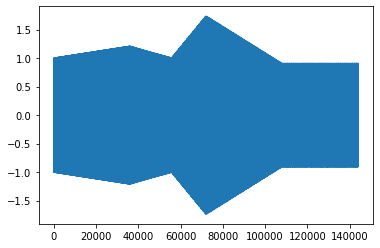

In [152]:
### TEST WAVE SHAPE MORPHING ###
N = num_samples_for_secs(3)
test_dict = {
    'waveshape': np.linspace(0, NUM_WAVES, N),
    'mode': const_inp(0, N),
    'coarse_adj': const_inp(0.015, N),
    'fine_adj': const_inp(0, N),
    'vpo': const_inp(0, N),
    'fm_exp': const_inp(0, N),
}
run_test(test_dict, N)